# Models for prediction of coronavirus COVID-19 infection in different countries 

Tomáš Kulhánek<sup>1,2</sup>, Jiří Kofránek<sup>1,2</sup>

<sup>1</sup>First Faculty of Medicine, Charles University of Prague <sup>2</sup>Creative Connections,s.r.o. 


This notebook contains comparison of logistic and exponential model in case of using is to predict coronavirus COVID-19 infection in different countries using public data and Python libraries to do Data-Science.

This is interactive Jupyter notebook, with text-cells and code-cells with python code. You can run the code cells and execute scripts there by pressing `Shift-Enter`. You can edit the cells, syntax and rerun the code.



In [1]:
# First we import related python libs used further
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
%matplotlib inline

In [2]:
#data from Italian national agency, seems to be updated in daily basis
def getdatafromItaly():
    url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    df = pd.read_csv(url)
    df = df.loc[:,['data','totale_casi']]
    FMT = '%Y-%m-%d %H:%M:%S'
    date = df['data']
    df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days  )
    return df

In [3]:
def getdatafromWHO(country,addlastdaynum=0):
    # using data from John Hopkins https://github.com/CSSEGISandData/COVID-19
    url3 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
    df3 = pd.read_csv(url3)
    #select country,region
    dfcz = df3.loc[df3['Country/Region']==country,:]
    #select only data relevant of coronavirus COVID-19, strip country name, location,... 
    dfcz2 = dfcz.iloc[:,4:]
    #strip columns where infected is 0
    dfcz21 = dfcz2.loc[:, (dfcz2 != 0).any(axis=0)]
    dfcz22 = dfcz21.rename(index={dfcz21.first_valid_index():"infected"},errors="raise")
    #transpose
    dfcz3 = dfcz22.transpose()
    #calculate number of days from 1.1.2020 based on date in first column
    d = (datetime.strptime(dfcz21.columns[0], "%m/%d/%y")-datetime(2020,1,1)).days
    #insert just day numbers 
    dfcz3.insert(0,'days',range(d,int(d+len(dfcz3.index))))
    #optionally append one number with most updated data - 13.3. number 113
    if (addlastdaynum>0):
        dfcz33 = dfcz3.append({"days":d+len(dfcz3.index),"infected":addlastdaynum},ignore_index=True)
        return dfcz33
    return dfcz3
    #print(dfcz33,df2)
    

In [4]:
def getdatafromCzechia():
    # TODO not found yet, manually inserted
    crdata=[['days','infected'],[61,3],[62,3],[63,5],[64,5],[65,8],[66,19],[67,26],[68,32],[69,38],[70,63],[71,94],[72,116]]
    df2 = pd.DataFrame(crdata[1:],columns=crdata[0])
    return df2

## Logistic model

$$ f(x,a,b,c)= \frac{c}{1+e^\frac{-(x-b)}{a} } $$

* $x$ time
* $a$ speed of infection
* $b$ critical point, day when most new infected recorded
* $c$ total number of infected people

https://en.wikipedia.org/wiki/Logistic_regression


In [6]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

# Exponential model
$$ f(x,a,b,c)= a.e^{b(x-c)} $$

In [7]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [8]:
def getxy(dfcz33):
    x = list(dfcz33.iloc[:,0])
    y = list(dfcz33.iloc[:,1])
    return (x,y)

def fitlogisticmodel(x,y):
    #fit data to logistic model
    fit = curve_fit(logistic_model,x,y,p0=[2,71,20000])
    #a,b,c parameters of model, c total infected, b reversal day number of daily infected starts decrease
    (a,b,c)=(fit[0][0],fit[0][1],fit[0][2])
    #lastday when somebody is infected
    lastday = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))
    #errors - uncertainty
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    #print('Parameters of logistic model fit a:',a,' b:',b,' c:',c,' errors of c:',errors[2])
    return (fit,lastday,errors)

In [9]:
def fitexponentialmodel(x,y):
    #fit data to exponential model
    exp_fit = curve_fit(exponential_model,x,y,p0=[0.02,0.1,2.8])
    return exp_fit


In [10]:
def plotchart(x,y,lastday,fit,exp_fit,errors):
    pred_x = list(range(max(x),lastday))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    # Predicted logistic curve
    plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
    # line with predicted total infected
    plt.axhline(y=fit[0][2], color='b', linestyle='dotted')
    plt.text(lastday-2,fit[0][2]*1.02,int(fit[0][2]))
    # uncertainty interval +- errors
    plt.axhline(y=fit[0][2]-errors[2], color='lightblue', linestyle='dotted')
    plt.axhline(y=fit[0][2]+errors[2], color='lightblue', linestyle='dotted')
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,fit[0][2]*1.1))
    plt.show()


In [11]:

def analyze_data(df):
    (x,y) = getxy(df)
    (fit,lastday,errors) = fitlogisticmodel(x,y)
    fit_exp = fitexponentialmodel(x,y)
    date_lastday=datetime(2020,1,1) + timedelta(days=lastday)    
    plotchart(x,y,lastday,fit,fit_exp,errors)
    return (date_lastday,fit,errors)
    
def analyze_for_country(country,addlastnum=0):
    # get data from WHO
    df = getdatafromWHO(country,addlastnum)
    (date_lastday,fit,errors) = analyze_data(df)
    print('Model of COVID-19 infection in',country,'based on real data predicts last infected person at ',date_lastday.strftime('%d.%m.%Y'),' with total infected people ',int(fit[0][2]),'(+-', int(errors[2]),'). ')


# Model prediction for Czechia

Data are available from [3] and [2]. The data reported differs. Thus comparing model prediction for both data.

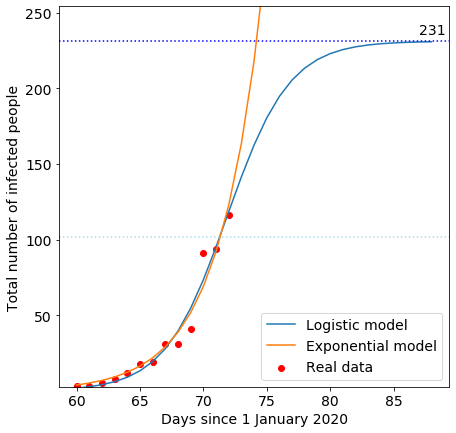

Model of COVID-19 infection in Czechia based on real data predicts last infected person at  30.03.2020  with total infected people  231 (+- 129 ). 


In [12]:
analyze_for_country('Czechia',116) #13.3.2020 total number of cases reported 116 - being updated manually

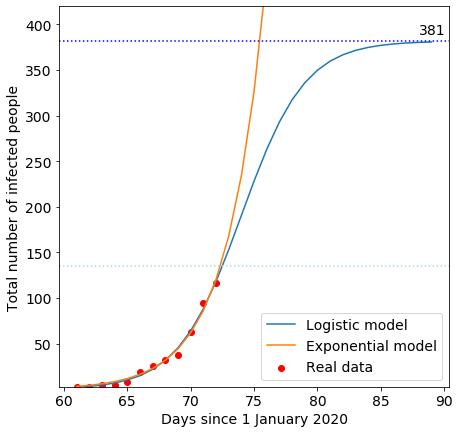

(datetime.datetime(2020, 3, 31, 0, 0),
 (array([  2.50173919,  74.00813953, 381.5760938 ]),
  array([[1.20081721e-01, 8.46685630e-01, 8.02741960e+01],
         [8.46685630e-01, 6.50596713e+00, 6.28080703e+02],
         [8.02741960e+01, 6.28080703e+02, 6.09256441e+04]])),
 [0.3465280951909946, 2.5506797378350585, 246.83120577634253])

In [13]:
dfcz = getdatafromCzechia()
analyze_data(dfcz)

## Summary for Czechia
Models are sensitive to real data, compared data from [2] and [3], predicted total infected people are 381 (+-246) vs 231 (+-129). Data reported by Czech news seems to be more credible, however, not yet found credible source in CSV or other format updated in daily basis.

Real Data seems not reach critical point (parameter b) thus logistic model prediction are still quite uncertain.

# Model prediction for South Korea

/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


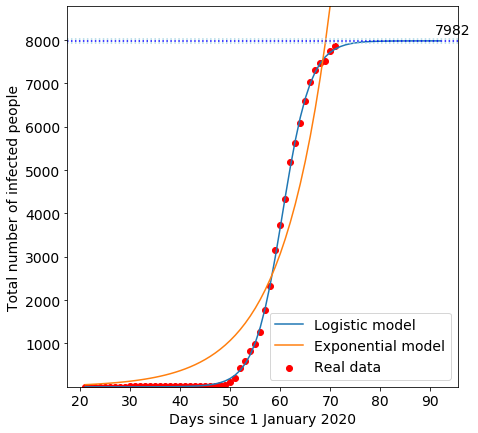

Model of COVID-19 infection in Korea, South based on real data predicts last infected person at  03.04.2020  with total infected people  7982 (+- 38 ). 


In [14]:

analyze_for_country('Korea, South')

## Summary for South Korea
Data seems to fit Logistic model after critical point (parameter b) and if nothing else unpredictable happens in South Korea, the model predicts the end of infection in the beginning of April with total infected people  7982 (+- 38 ). 

# Model prediction for Italy

Data are available from [1] and [3]. Comparing model prediction for both data sources.

/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


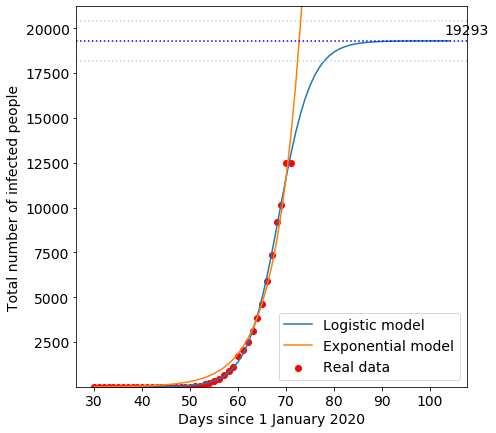

Model of COVID-19 infection in Italy based on real data predicts last infected person at  15.04.2020  with total infected people  19293 (+- 1111 ). 


In [15]:
analyze_for_country('Italy')

/home/vagrant/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


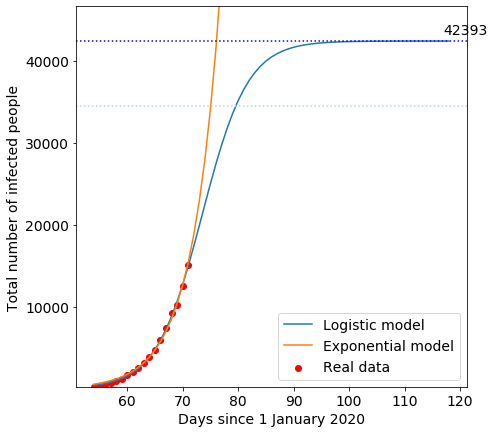

(datetime.datetime(2020, 4, 29, 0, 0),
 (array([4.11963085e+00, 7.35212346e+01, 4.23935968e+04]),
  array([[3.47644866e-02, 2.22024437e-01, 1.37646404e+03],
         [2.22024437e-01, 1.55006317e+00, 9.79393484e+03],
         [1.37646404e+03, 9.79393484e+03, 6.22185213e+07]])),
 [0.18645237073072998, 1.2450153302867664, 7887.8717855282])

In [16]:
df3=getdatafromItaly()
analyze_data(df3)

## Summary for Italy 
Models are sensitive to real data, compared data from [1] and [3], predicted total infected people are 42393 (+-7887) vs 19293 (+-1111). Data directly from Italian source seems to be more credible.

Real Data seems not reach critical point (parameter b) thus logistic model prediction are still quite uncertain, and exponential growth is still in place.

# Other countries

In [19]:
# do analysis for your country, check correct country/region name in data source [3]
url3 = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
df3 = pd.read_csv(url3)
df3.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,43,43,47,48,50,50,50,53,59,70
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,293,331,360,420,461,502,511,581,639,639
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,110,110,117,130,138,150,150,160,178,178
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,36,50,50,83,93,99,117,129,149,149


In [ ]:
# insert country name instead of ...
analyze_for_country(...)

# References
* [1] models, algorithms and data from Italy https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* [2] data from Czechia https://www.kurzy.cz/zpravy/533079-mapa-koronaviru-aktualni-mapy-vyskytu-potvrzenych-pripadu-koronaviru-covid-19-mapa-koronaviru-v/
* [3] world data updated by Johns Hopkins University Center for Systems Science and Engineering https://github.com/CSSEGISandData/COVID-19